# Cardiocascular Disease Analysis

The purpose of this notebook is to analyze this [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea) and create a model for predicting 10 year risk of coronary heart disease.


1. Data loading and cleaning
2. EDA
3. Modelling


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve
)
from sklearn.model_selection import cross_val_score, cross_validate
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 1. Data Loading and Cleaning


I'll use the `train.csv` file in this analysis


In [ ]:
df = pd.read_csv("datasets/cardiovascular_study/train.csv")
df.shape

(3390, 17)

let's look at our data!

In [ ]:
df.sample(10)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
257,257,38,2.0,M,YES,40.0,0.0,0,1,0,245.0,154.0,95.5,30.02,92.0,87.0,0
764,764,54,3.0,M,YES,20.0,0.0,0,1,0,298.0,133.0,84.0,25.59,90.0,94.0,0
298,298,52,1.0,M,YES,2.0,0.0,0,0,0,246.0,122.0,81.0,27.61,90.0,98.0,0
749,749,61,3.0,F,NO,0.0,0.0,0,0,0,257.0,141.0,80.0,33.90,85.0,60.0,1
1699,1699,37,2.0,F,YES,5.0,0.0,0,0,0,185.0,100.0,68.0,18.38,70.0,72.0,0
1993,1993,53,1.0,M,YES,10.0,0.0,0,1,1,229.0,146.5,82.0,27.80,60.0,172.0,0
1703,1703,38,1.0,F,NO,0.0,0.0,0,0,0,214.0,115.0,90.0,25.69,80.0,65.0,0
273,273,57,1.0,F,NO,0.0,0.0,0,1,0,254.0,182.5,97.0,27.38,77.0,72.0,0
1471,1471,48,2.0,M,YES,20.0,0.0,0,0,0,194.0,102.5,69.0,18.55,79.0,83.0,0
292,292,64,1.0,F,NO,0.0,0.0,0,0,0,320.0,130.0,77.0,26.24,70.0,74.0,0


At first look the dataset seems quite clean. We might be dealing with class imbalance (as is often the case with disease datasets), but we will investigate that more thoroughly in the modelling step.

One thing I don't think I'll need is the `id` column, let's remove it.

In [ ]:
df = df.drop(columns=["id"])

Let's describe the dataset and check missing values.


In [ ]:
df.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [ ]:
df.apply(lambda x: np.mean(x.isnull()), axis=0)

age                0.000000
education          0.025664
sex                0.000000
is_smoking         0.000000
cigsPerDay         0.006490
BPMeds             0.012979
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.011209
sysBP              0.000000
diaBP              0.000000
BMI                0.004130
heartRate          0.000295
glucose            0.089676
TenYearCHD         0.000000
dtype: float64

I notice two things:
1. There are some missing values in `cigsPerDay`, `BPMeds`, `totChol`, `BMI`, `heartRate`, `glucose` columns. Overall there are few such cases, so I will impute those variable in the modeling step.
2. I don't understand the `education` column. Given that it's numeric, I expected it to be years of education, but instead it seems to be a categorical variable (middle, higher, etc). However, the dataset documentation does not mention this column at all, so I would have to make an assumption about what this column means. Let's get rid of that column instead.

In [ ]:
df = df.drop(columns=["education"])

And that concludes our data loading and cleaning step



## 2. Exploratory Data Analysis

The goal of EDA is to simply look at data via plots, raise questions and find issues that I would have to address in the modeling step. However, before I do that, I would like to better understand the domain of the problem
Here are the references that I used to get familiar with CHD and its risk factors



First let's inspect the target variable, `TenYearCHD`.

In [ ]:
df["TenYearCHD"].value_counts()

TenYearCHD
0    2879
1     511
Name: count, dtype: int64

As suspected, we have significant class imbalance. I'll come back to this issue in the modeling step.

Next let's inspect correlation between the target and continuous variables via boxplots.

In [ ]:
continuous_feats = [
    "age",
    "cigsPerDay",
    "totChol",
    "diaBP",
    "sysBP",
    "BMI",
    "heartRate",
    "glucose"
]

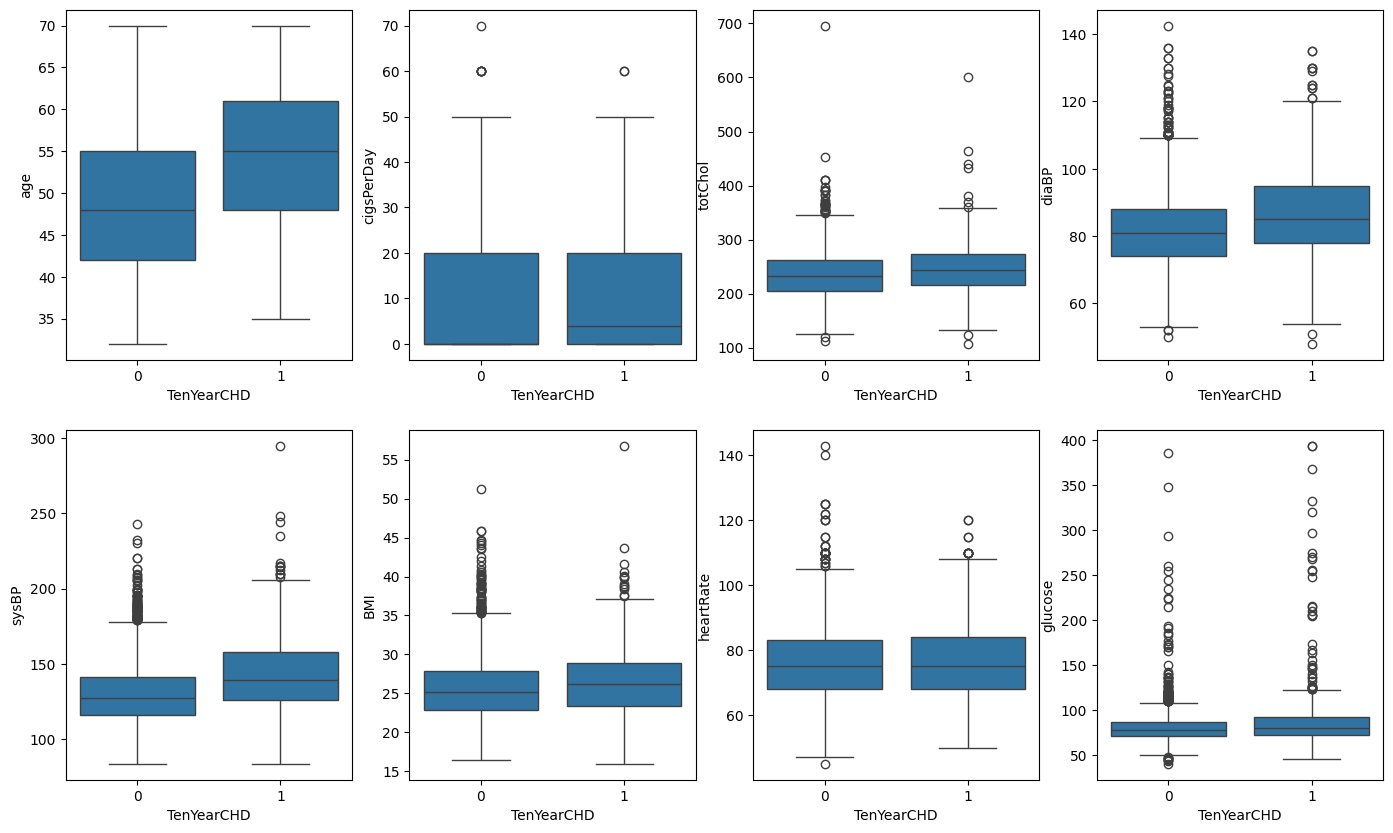

In [ ]:
cols = 4
fig, axs = plt.subplots(2, 4, figsize=(17, 10))

for i, feature in enumerate(continuous_feats):
    sns.boxplot(data=df, x="TenYearCHD", y=feature, ax=axs[i//cols, i%cols])


From the eight plots above, it is immediately obvious that most risk factors are only weak predictors of CHD. Humans are complex creatures. Some features that do stand out, however, are `age`, `diaBP` (diastolic blood pressure) and `sysBP` (systolic blood pressure).

Let's inspect categorical features next.

In [ ]:
categorical_feats = [
    "prevalentStroke",
    "prevalentHyp",
    "diabetes",
    "sex",
    "is_smoking"
]

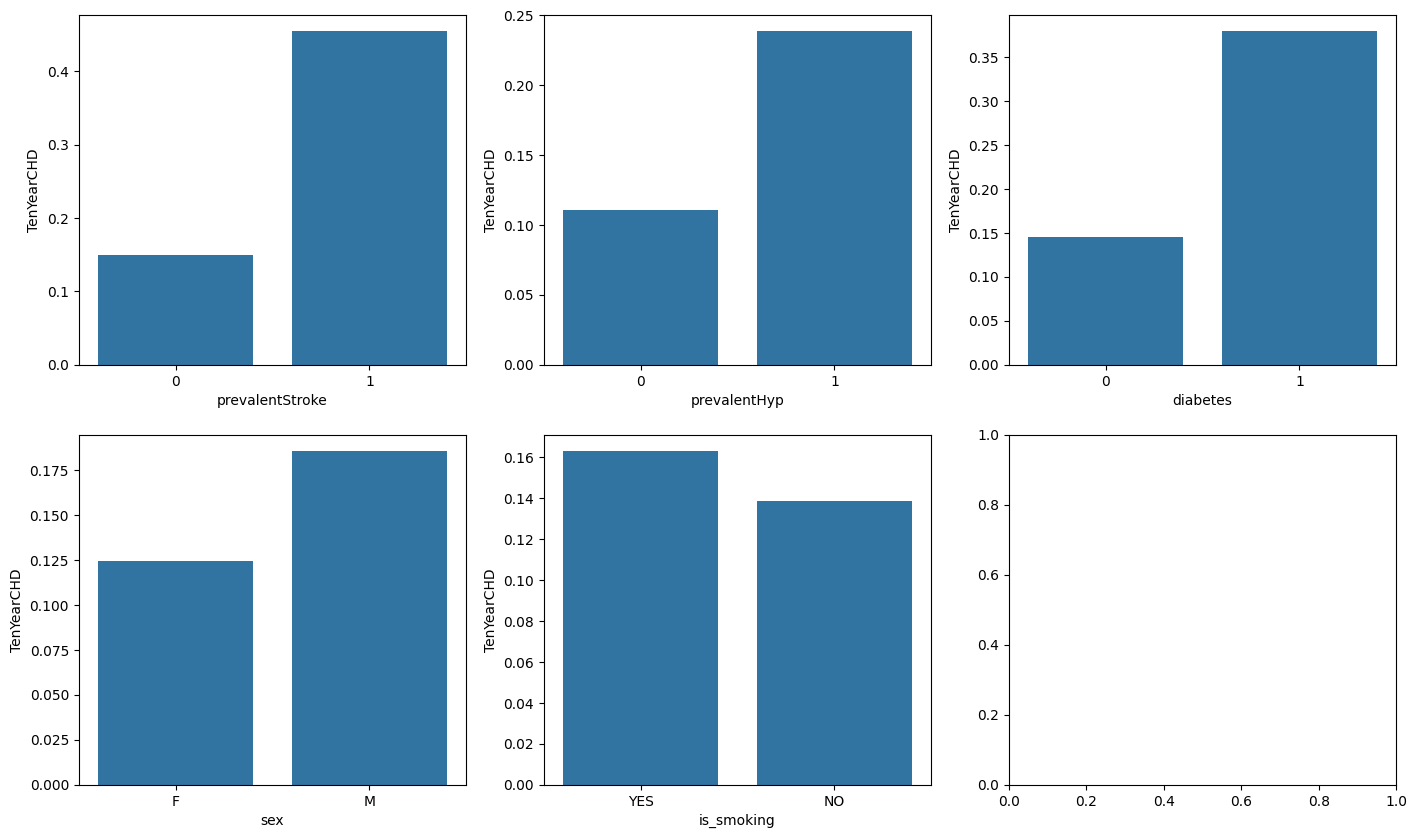

In [ ]:
cols = 3
fig, axs = plt.subplots(2, cols, figsize=(17, 10))

for i, feature in enumerate(categorical_feats):
    sns.barplot(data=df, x=feature, y="TenYearCHD", errorbar=None, ax=axs[i//cols, i%cols])

People who have hypertension or diabetes, or have had a stroke before, are more likely to suffer from CHD in ten years. This makes sense. Also, male study participants seem to have higher risk of CHD. Meanwhile, the mere fact of smoking seems to also be quite predictive of CHD risk. Here I would like to know how this variable is operationalized - how frequently a study participant has to smoke to be considered a smoker. Sadly this information is not available.

What about multicollinearity? Obviously, `is_smoking` is correlated with `cigsPerDay`, but [research indicates](https://pubmed.ncbi.nlm.nih.gov/18192832/) that) `sysBP` should be correlated to `diaBP`.

<Axes: xlabel='diaBP', ylabel='sysBP'>

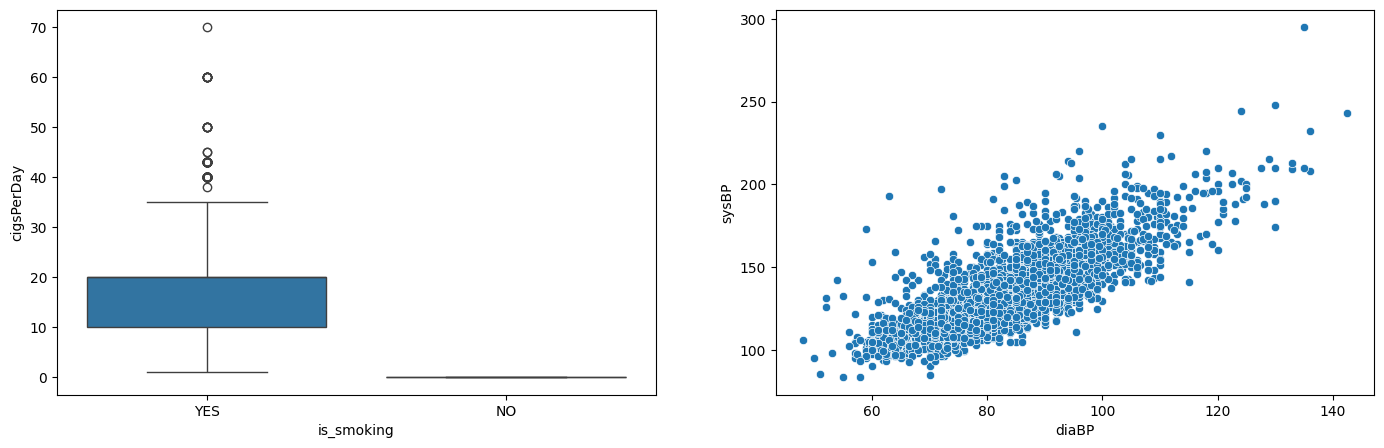

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

sns.boxplot(data=df, y="cigsPerDay", x="is_smoking", ax=axs[0])
sns.scatterplot(data=df, x="diaBP", y="sysBP", ax=axs[1])


Indeed that is the case, however, I think it is safe to ignore it. If these variables were close to perfectly correlated, then we could exclude them without losing predictive power. However, separately these variables might contain information that would make our model more accurate. And, just as a reminder, we are making a *predictive* model. If we were making an explanatory model, multicollinearity would be an issue.

## 3. Modeling

Let's fit a logistic regression model for predicting ten year CHD risk!

In [ ]:
y = df["TenYearCHD"]
X = df.drop(columns=["TenYearCHD"])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Encode Categorical Features

`sex` and `is_smoking` features are not numeric, let's transform them to a binary vector using scikit-learn's OneHotEncoder.

In [ ]:
encode_features = ["sex", "is_smoking"]

In [ ]:
encoder = OneHotEncoder(
    drop="first",
    # Hardcoded categories to avoid errors when the test set has missing categories
    categories=[["F", "M"], ["YES", "NO"]],
)

In [ ]:
X_train_categorical_encoded = pd.DataFrame(
    encoder.fit_transform(X_train[encode_features]).toarray(),
    columns=encoder.get_feature_names_out(encode_features),
    index=X_train.index,
)
X_train = X_train.drop(columns=categorical_feats).join(X_train_categorical_encoded)


### Impute

Let's impute the features that contain missing values. For categorical features I will use the most frequent value and for continuous features I will use the median.

In [ ]:
continuous_feats_impute = ["cigsPerDay", "totChol", "BMI", "heartRate", "glucose"]
categorical_feats_impute = ["BPMeds"]

In [ ]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
continuous_imputer = SimpleImputer(strategy="median")
X_train[categorical_feats_impute] = categorical_imputer.fit_transform(X_train[categorical_feats_impute])
X_train[continuous_feats_impute] = continuous_imputer.fit_transform(X_train[continuous_feats_impute])


### Fit first model

In [ ]:
model = LogisticRegression(fit_intercept=True, max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Let's evaluate this model on the training set using accuracy as the metric.

In [ ]:
y_train_pred = model.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.8587758112094396

Not bad! We are achieving accuracy of 85%.

But in the EDA we saw clearly that there is high class imbalance in our dataset. What accuracy score would we get if we always predicted no disease?

In [ ]:
accuracy_score(y_train, np.zeros(y_train.shape[0]))

0.8499262536873157

We get accuracy that is almost the same as using model predictions. This should not be surprising, since the disease is quite rare. We can see the same when inspecting other classification metrics. scikit-learn provides a very useful method for that - `classification_report`.


In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2305
           1       0.72      0.10      0.17       407

    accuracy                           0.86      2712
   macro avg       0.79      0.54      0.55      2712
weighted avg       0.84      0.86      0.81      2712



The main issue with our model is obvious - very low recall for the positive class. That is, out of all people with who have 10 year risk of heart disease, our model identifies only 10%. Some of that is what I already mentioned - humans are complex and predicting disease is hard. But we can also try to create a better model.

But how do we check if it is actually improving? We cannot just test it on the training data, since we can get arbitrarily good performance on the training data by overfitting. We cannot use the test data since that is for reporting the performance oft the final model.

This is where cross validation is very useful. First, let's find the cross-validated performance of our current model.


In [ ]:
cv = cross_validate(
    model, X_train, y_train, cv=20, scoring=["accuracy", "precision", "recall", "f1_macro"]
)

/Users/haroldas.mackevicius/turing-college/da-solutions/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def print_cv_metrics(cv):
    df = pd.DataFrame(cv)
    df = df.drop(columns=["fit_time", "score_time"])
    df = df.melt(var_name="metric", value_name="score").groupby("metric").mean().round(3)
    print(df)

In [ ]:
print_cv_metrics(cv)

                score
metric               
test_accuracy   0.857
test_f1_macro   0.539
test_precision  0.652
test_recall     0.091


Now let's create a new model that addresses the imbalance issue. There are many techniques for this, but logistic regression implementation in scikit-learn is quite neat because it has the `class_weight` parameter. By setting this parameter to `balanced`, we're telling the model to assign bigger weights to the underrepresented class during training.

Let's fit a new model and inspect cross validation metrics.

In [ ]:
model_balanced = LogisticRegression(fit_intercept=True, max_iter=10000, class_weight="balanced")


In [ ]:
cv_balanced = cross_validate(
    model_balanced, X_train, y_train, cv=20, scoring=["accuracy", "precision", "recall", "f1_macro"]
)

In [ ]:
print_cv_metrics(cv_balanced)

                score
metric               
test_accuracy   0.673
test_f1_macro   0.580
test_precision  0.268
test_recall     0.671


Looking at the F1 Macro metric, we see that setting the `class_weight` parameter to `balanced` improved model performance by 4 percentage points. That's a modest gain, but a gain nonetheless.

We could keep improving the model pretty much endlessly, each time checking the cross validation metrics. For instance, we could experiment with  hyperparameter tuning.

Let's refit the model on the full training set.

In [ ]:
model_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

### Evaluate on test set

Let's see how the model performs on the test set.

In [ ]:
X_test_categorical_encoded = pd.DataFrame(
    encoder.transform(X_test[encode_features]).toarray(),
    columns=encoder.get_feature_names_out(encode_features),
    index=X_test.index,
)
X_test = X_test.drop(columns=categorical_feats).join(X_test_categorical_encoded)


In [ ]:
X_test[categorical_feats_impute] = categorical_imputer.transform(X_test[categorical_feats_impute])
X_test[continuous_feats_impute] = continuous_imputer.transform(X_test[continuous_feats_impute])


In [ ]:
y_pred = model_balanced.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75       574
           1       0.24      0.63      0.35       104

    accuracy                           0.64       678
   macro avg       0.57      0.64      0.55       678
weighted avg       0.80      0.64      0.69       678



It's also a good idea to look at the confusion matrix.

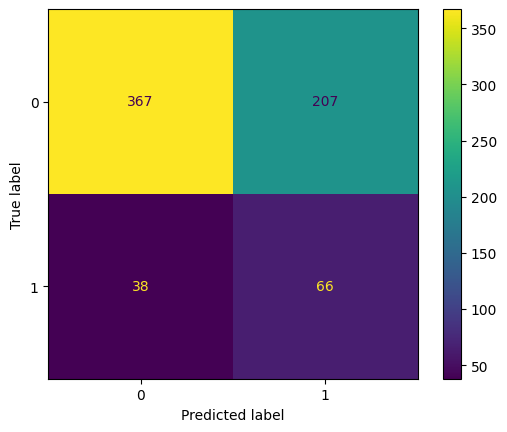

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

Indeed, predicting heart disease is hard and we've only been able to achieve F1 Macro performance of 0.55. We most probably could improve the model further via hyperparameter tuning and feature engineering, or by experimenting with other kinds of algorithms, such as random forests.

### Threshold tuning

When we make predictions using `model.predict`, we apply the threshold of 0.5 to probabilities that the fitted logistic regression model outputs. But is that the optimal threshold?


In [ ]:
# Taking the probability of the positive class
y_pred_proba = model_balanced.predict_proba(X_test)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_score = 2 * (precision * recall) / (precision + recall)


<Axes: >

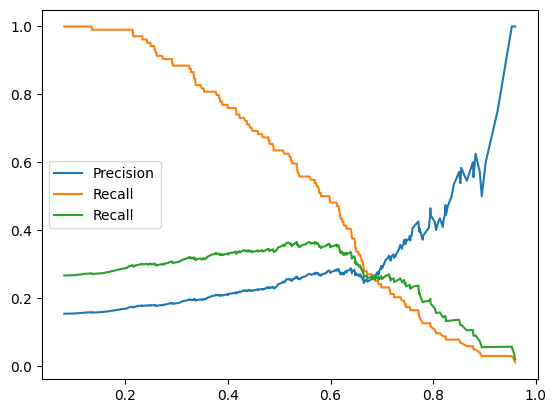

In [ ]:
sns.lineplot(x=thresholds, y=precision[:-1], label="Precision")
sns.lineplot(x=thresholds, y=recall[:-1], label="Recall")
sns.lineplot(x=thresholds, y=f1_score[:-1], label="Recall")


Indeed F1 seems to be at the maximum at around 0.5. However, it might make sense to lower the threshold to 0.3 or even lower if we really care about having good recall.